In [2]:
import sys, pathlib
import pandas as pd
import numpy as np
import joblib

# Ruta al proyecto
PROJECT_ROOT = pathlib.Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# ✅ FORZAR RELOAD CONFIG PARA LSTM NORMAL
import importlib
from src import config as cfg
importlib.reload(cfg)  # Fuerza recarga de la nueva configuración
from src import evol_utils as eu
from sklearn.preprocessing import StandardScaler

# === Paths dinámicos ===
if cfg.MODEL_TYPE == "lstm":
    MODEL_PATH = cfg.MODELS / cfg.LSTM_MODEL_NAME
    DATA_PATH  = cfg.DATA / "processed" / "lstm_data.pkl"
elif cfg.MODEL_TYPE == "lstm5d":
    MODEL_PATH = cfg.MODELS / cfg.LSTM5D_MODEL_NAME
    DATA_PATH  = cfg.DATA / "processed" / "lstm5d_data.pkl"
elif cfg.MODEL_TYPE == "gru5d":
    MODEL_PATH = cfg.MODELS / cfg.GRU5D_MODEL_NAME
    DATA_PATH = cfg.DATA / "processed" / "gru5d_data.pkl"
elif cfg.MODEL_TYPE == "ridge":
    MODEL_PATH = cfg.MODELS / "ridge.pkl"
    DATA_PATH  = cfg.DATA / "processed" / "lstm_data.pkl"
elif cfg.MODEL_TYPE == "xgb":
    MODEL_PATH = cfg.MODELS / cfg.XGB_MODEL_NAME
    DATA_PATH  = cfg.DATA / "processed" / "xgb_data.pkl"
elif cfg.MODEL_TYPE == "xgb_enhanced":
    MODEL_PATH = cfg.DATA / "processed" / "xgb_enhanced_model.pkl"  # ✅ FIX: Path correcto donde se guardó
    DATA_PATH  = cfg.DATA / "processed" / "xgb_enhanced_data.pkl"
elif cfg.MODEL_TYPE == "markowitz":
    MODEL_PATH = None  # Markowitz no necesita modelo entrenado
    DATA_PATH  = cfg.DATA / "processed" / "lstm_data.pkl"  # Solo necesita tickers
elif cfg.MODEL_TYPE == "cnn5d":
    MODEL_PATH = cfg.MODELS / "cnn5d.keras"
    DATA_PATH = cfg.DATA / "processed" / "cnn5d_data.pkl"
    scaler_cnn5d = joblib.load(cfg.MODELS / "scaler_X_cnn5d.pkl")


else:
    raise ValueError(f"Modelo '{cfg.MODEL_TYPE}' no soportado")

PRICES_PATH = cfg.DATA / "raw" / "prices.parquet"

print(f"🧠 Modelo activo: {cfg.MODEL_TYPE}")

🧠 Modelo activo: lstm


In [3]:
# === Datos ===
df_prices = pd.read_parquet(PRICES_PATH).sort_index()
lstm_data = joblib.load(DATA_PATH)

# ✅ FIX: Extraer tickers según estructura de datos
if cfg.MODEL_TYPE in ["xgb_enhanced"]:
    # XGB Enhanced: DataFrame directo con columna 'ticker'
    tickers = lstm_data['ticker'].unique().tolist()
elif isinstance(lstm_data, dict) and "tickers" in lstm_data:
    # LSTM/otros: diccionario con clave 'tickers'
    tickers = lstm_data["tickers"]
else:
    # Fallback: usar tickers de precios existentes
    tickers = df_prices.columns.tolist()

df_prices = df_prices[tickers]
df_ret = np.log(df_prices / df_prices.shift(1)).dropna()

# ✅ OPTIMIZACIÓN: Solo calcular features necesarias según el modelo
if cfg.MODEL_TYPE == "lstm":
    # LSTM-1d: SOLO necesita retornos - NO calcular momentum innecesario
    df_feat = df_ret.shift(1).dropna()  # Solo retornos desplazados
    print("✅ LSTM-1d optimizado: solo retornos (40 features)")
    
elif cfg.MODEL_TYPE == "lstm5d":
    # LSTM5d: necesita retornos + momentum + VIX
    vix = pd.read_parquet(cfg.DATA / "raw" / "vix.parquet").squeeze()
    vix = vix.ffill().reindex(df_ret.index).ffill()
    vix_t1 = vix.shift(1).rename('vix_t-1')
    
    # Momentum solo para LSTM5d
    ret5 = df_ret.rolling(5).sum()
    vol5 = df_ret.rolling(5).std()
    momentum = (ret5 / vol5).shift(1)
    
    df_feat = pd.concat([df_ret.shift(1), momentum, vix_t1], axis=1).dropna()
    print("✅ LSTM5d: retornos + momentum + VIX (81 features)")
    
else:
    # Otros modelos: retornos + momentum (sin VIX)
    ret5 = df_ret.rolling(5).sum()
    vol5 = df_ret.rolling(5).std()
    momentum = (ret5 / vol5).shift(1)
    df_feat = pd.concat([df_ret.shift(1), momentum], axis=1).dropna()
    print(f"✅ {cfg.MODEL_TYPE}: retornos + momentum (80 features)")

print("✅ df_feat shape:", df_feat.shape)

# === Cargar modelo y escalador ===
if cfg.MODEL_TYPE in ["lstm", "lstm5d","cnn5d"]:
    from tensorflow import keras
    # ✅ FIX: Deshabilitar safe_mode para cargar capas Lambda custom
    model = keras.models.load_model(MODEL_PATH, compile=False, safe_mode=False)
elif cfg.MODEL_TYPE == "gru5d":
    from tensorflow import keras
    model = keras.models.load_model(cfg.MODELS / cfg.GRU5D_MODEL_NAME, compile=False, safe_mode=False)
    DATA_PATH = cfg.DATA / "processed" / "gru5d_data.pkl"
elif cfg.MODEL_TYPE == "ridge":
    model = joblib.load(MODEL_PATH)
elif cfg.MODEL_TYPE == "xgb":
    model = joblib.load(MODEL_PATH)
elif cfg.MODEL_TYPE == "xgb_enhanced":
    model = joblib.load(MODEL_PATH)  # XGBoost enhanced usa el mismo mecanismo
elif cfg.MODEL_TYPE == "markowitz":
    model = None  # Markowitz no necesita modelo entrenado (usa medias históricas)
else:
    raise ValueError(f"Modelo '{cfg.MODEL_TYPE}' no soportado")

# Solo para lstm5d
if cfg.MODEL_TYPE == "lstm5d":
    scaler_lstm5d = joblib.load(cfg.MODELS / "scaler_X_lstm5d.pkl")


✅ LSTM-1d optimizado: solo retornos (40 features)
✅ df_feat shape: (2703, 40)



In [4]:
# 🔧 CORRECCIÓN CRÍTICA LSTM-5d: Agregar VIX para completar 81 features
if cfg.MODEL_TYPE == "lstm5d":
    # Cargar VIX y alinearlo con los precios
    vix = pd.read_parquet(cfg.DATA / "raw" / "vix.parquet").squeeze()
    vix = vix.ffill().reindex(df_ret.index).ffill()
    vix_t1 = vix.shift(1).rename('vix_t-1')
    
    # Recrear features completas: retornos + momentum + VIX
    df_feat = pd.concat([df_ret.shift(1), momentum, vix_t1], axis=1).dropna()
    print("🔧 df_feat shape CORREGIDO (con VIX):", df_feat.shape)
    print("✅ Features: retornos(40) + momentum(40) + VIX(1) = 81")
    print("✅ Dimensiones compatibles con modelo LSTM-5d")
else:
    print("✅ df_feat shape original:", df_feat.shape)


✅ df_feat shape original: (2703, 40)


In [5]:
from src import config as cfg
import joblib

ruta = cfg.MODELS / "scaler_y_lstm.pkl"
print("📦 Escalador existe:", ruta.exists())


📦 Escalador existe: True


In [6]:
# ───────────────────────────────────────────────────────────────────────────────
# rebalanceo.py  – función rebalancear_en_fecha  (versión SIN warnings)
# ───────────────────────────────────────────────────────────────────────────────
import joblib, numpy as np, pandas as pd, src.evol_utils as eu  # resto igual …
from src import predict_ridge
from src import predict_xgb_enhanced
import importlib
import warnings

# ✅ SILENCIAR WARNINGS ESPECÍFICOS de yfinance y pandas
warnings.filterwarnings('ignore', message='.*YF.download.*auto_adjust.*')
warnings.filterwarnings('ignore', message='.*Downcasting object dtype.*')

# ✅ FORCE RELOAD módulo XGB Enhanced para aplicar cambios yfinance
importlib.reload(predict_xgb_enhanced)
from src.predict_xgb_enhanced import predict_xgb_enhanced

def _lazy_loader(var_name, pkl_path):
    if var_name not in globals():
        globals()[var_name] = joblib.load(pkl_path)
    return globals()[var_name]


def rebalancear_en_fecha(fecha, df_feat, model, w_prev=None):
    try:
        idx     = df_feat.index.get_loc(fecha)
        ventana = df_feat.iloc[idx - cfg.WINDOW: idx]

        # ── 1. PREDICCIÓN ───────────────────────────────────────────────────
        if cfg.MODEL_TYPE == "lstm":
            # ✅ FIX DEFINITIVO: Usar el escalador del preprocessing que SÍ existe
            ventana_ret = df_ret.iloc[idx - cfg.WINDOW: idx]  # (60, 40) solo retornos
            
            # Cargar el escalador original del preprocessing que EXISTE
            data_scaler = _lazy_loader("ret_scaler", cfg.DATA / "processed" / "ret_scaler.pkl")
            
            # ✅ ESCALADO CORRECTO: aplicar el mismo escalado que en entrenamiento
            # Los datos ya vienen pre-escalados en el entrenamiento, pero necesitamos escalar raw data
            X_scaled = data_scaler.transform(ventana_ret.values)  # (60, 40) escalado
            X_input = X_scaled.reshape(1, cfg.WINDOW, -1)  # (1, 60, 40)
            
            # Predicción (modelo entrenado con datos pre-escalados, devuelve escalado)
            r_hat_scaled = model.predict(X_input, verbose=0)[0]
            
            # ✅ CONVERSIÓN A ESCALA ORIGINAL: el modelo devuelve predicciones escaladas
            r_hat = data_scaler.inverse_transform([r_hat_scaled])[0]
            
            # ✅ LOGGING DEBUG para verificar variabilidad
            if fecha == fechas[cfg.WINDOW]:  # Primera fecha
                print(f"🔍 DEBUG LSTM-1d - ventana range: [{ventana_ret.min().min():.6f}, {ventana_ret.max().max():.6f}]")
                print(f"🔍 DEBUG LSTM-1d - r_hat range: [{r_hat.min():.6f}, {r_hat.max():.6f}]")
            
            r_hat = np.clip(r_hat, -0.08, 0.08)

        elif cfg.MODEL_TYPE == "lstm5d":
            # ✅ CONSTRUIR FEATURES LSTM5D CON VIX (81 features = 40+40+1)
            ventana_ret = df_ret.iloc[idx - cfg.WINDOW: idx]
            ret5        = df_ret.rolling(5).sum()
            vol5        = df_ret.rolling(5).std()
            momentum    = (ret5 / (vol5 + 1e-6)).shift(1)
            ventana_mom = momentum.loc[ventana_ret.index]
            
            # Cargar VIX y alinearlo  
            vix = pd.read_parquet(cfg.DATA / "raw" / "vix.parquet").squeeze()
            vix_t1 = vix.shift(1).reindex(ventana_ret.index).ffill()            
            # Combinar: [retornos(40) + momentum(40) + vix(1)] = 81 features
            ventana_vix = vix_t1.values.reshape(-1, 1)  # (60, 1)
            ventana_combined = np.concatenate([
                ventana_ret.values,      # (60, 40) retornos
                ventana_mom.values,      # (60, 40) momentum  
                ventana_vix              # (60, 1)  VIX
            ], axis=1)  # (60, 81) ✅
            
            scaler_X = _lazy_loader("scaler_X_lstm5d", cfg.MODELS / "scaler_X_lstm5d.pkl")
            X_scaled = scaler_X.transform(ventana_combined)    # (60, 81)
            X_input  = X_scaled.reshape(1, cfg.WINDOW, -1)     # (1, 60, 81) ✅
            r_hat    = model.predict(X_input, verbose=0)[0]
            scaler_y = _lazy_loader("scaler_y_lstm5d", cfg.MODELS / "scaler_y_lstm5d.pkl")
            r_hat    = scaler_y.inverse_transform([r_hat])[0]



        elif cfg.MODEL_TYPE == "cnn5d":
            scaler_X = _lazy_loader("scaler_X_cnn5d", cfg.MODELS / "scaler_X_cnn5d.pkl")
            # ✅ CORRECCIÓN CNN5D: Preparar formato 4D correcto
            n_assets = len(tickers)        # 40 assets
            n_chan   = 2                   # [ret, momentum]
            
            # Reshape ventana para CNN: (W, 2*n_assets) → (W, n_assets, 2)
            ventana_ret = ventana.iloc[:, :n_assets].values      # (W, 40)
            ventana_mom = ventana.iloc[:, n_assets:].values      # (W, 40)
            ventana_4d = np.stack([ventana_ret, ventana_mom], axis=-1)  # (W, 40, 2)
            
            # Escalar: (W, n_assets, 2) → (W, n_assets*2) → scale → reshape back
            ventana_flat = ventana_4d.reshape(cfg.WINDOW, -1)   # (60, 80)
            X_scaled = scaler_X.transform(ventana_flat)         # (60, 80)
            X_4d = X_scaled.reshape(cfg.WINDOW, n_assets, n_chan)  # (60, 40, 2)
            X_input = X_4d.reshape(1, cfg.WINDOW, n_assets, n_chan)  # (1, 60, 40, 2)
            
            r_hat = model.predict(X_input, verbose=0)[0]
            scaler_y = _lazy_loader("scaler_y_cnn5d", cfg.MODELS / "scaler_y_cnn5d.pkl")
            r_hat = scaler_y.inverse_transform([r_hat])[0]   # vuelve a puntos %
            r_hat = r_hat / 5.0                              # de 5-d → 1-d
            r_hat = np.clip(r_hat, -0.12, 0.12)              # safety-clip ±12 %

        elif cfg.MODEL_TYPE == "gru5d":
            ventana_ret = df_ret.iloc[idx - cfg.WINDOW: idx]
            ret5        = df_ret.rolling(5).sum()
            vol5        = df_ret.rolling(5).std()
            momentum    = (ret5 / (vol5 + 1e-6)).shift(1)
            ventana_mom = momentum.loc[ventana_ret.index]
            ventana     = pd.concat([ventana_ret, ventana_mom], axis=1)

            scaler_X = _lazy_loader("scaler_X_gru5d", cfg.MODELS / "scaler_X_gru5d.pkl")
            X_scaled = scaler_X.transform(ventana.values)      # ← .values
            X_input  = X_scaled.reshape(1, cfg.WINDOW, -1)
            r_hat    = model.predict(X_input, verbose=0)[0]
            scaler_y = _lazy_loader("scaler_y_gru5d", cfg.MODELS / "scaler_y_gru5d.pkl")
            r_hat    = scaler_y.inverse_transform([r_hat])[0]
            # ✅ CONVERSIÓN CRÍTICA: de predicción 5-días → 1-día
            r_hat    = r_hat / 5.0
            r_hat    = np.clip(r_hat, -0.08, 0.08)

        elif cfg.MODEL_TYPE == "xgb":
            X_input = ventana.values                          # XGB sin escalar
            r_hat   = np.array([model[i].predict(X_input[-1].reshape(1, -1))[0]
                                for i in range(X_input.shape[1])])
        elif cfg.MODEL_TYPE == "ridge":
            r_hat_ser = predict_ridge.predict_ridge(df_prices, fecha, tickers)
            r_hat    = r_hat_ser.reindex(tickers).infer_objects(copy=False).fillna(0).values  # ✅ FIX FutureWarning
        elif cfg.MODEL_TYPE == "xgb_enhanced":
            r_hat_ser = predict_xgb_enhanced(df_prices, fecha, tickers)
            r_hat    = r_hat_ser.reindex(tickers).infer_objects(copy=False).fillna(0).values  # ✅ FIX FutureWarning
            r_hat    = np.clip(r_hat, -0.12, 0.12)  # Safety clip para features avanzadas
        elif cfg.MODEL_TYPE == "markowitz":
            # Markowitz clásico: usa medias históricas de 60 días
            ventana_ret = df_ret.iloc[idx - cfg.WINDOW: idx]
            r_hat = ventana_ret.mean().values  # Media histórica como predicción
            r_hat = np.clip(r_hat, -0.05, 0.05)  # Clip conservador para medias
        else:
            raise ValueError("Tipo de modelo no reconocido")

        # ── 2. OPTIMIZACIÓN (sin cambios) ──────────────────────────────────
        fecha_ret   = df_feat.index[idx]
        ventana_ret = df_ret.loc[:fecha_ret - pd.Timedelta(days=1)].tail(cfg.WINDOW)
        Sigma       = ventana_ret.cov().values

        if r_hat.shape[0] != Sigma.shape[0]:
            print(f"⚠️ Dim mismatch {fecha.date()}")
            return None

        res     = eu.resolver_optimizacion(r_hat, Sigma, w_prev=w_prev)
        w_star  = eu.elegir_w_star(res, r_hat, Sigma, w_prev=w_prev)

        turnover  = np.sum(np.abs(w_star - w_prev)) if w_prev is not None else 1.0
        
        # ✅ CORREGIR DATA LEAKAGE: NO usar retornos futuros para ret_bruto
        # En backtest real, solo conocemos retornos hasta fecha actual
        # ret_bruto debe calcularse período por período en el loop principal
        # Por ahora, usamos ret_bruto = 0 (se calculará en el loop)
        ret_bruto_sum = 0.0  # Se calculará externamente con datos reales
        ret_neto  = ret_bruto_sum - turnover * cfg.COST_TRADE

        return {
            "fecha"    : fecha,
            "r_hat"    : r_hat,
            "ret_bruto": ret_bruto_sum,  # ✅ Corregido: sin data leakage
            "ret_neto" : ret_neto,
            "turnover" : turnover,
            "w_star"   : w_star,
        }

    except Exception as e:
        print(f"ERROR {fecha.date()}: {e}")
        return None


In [7]:
fechas = df_feat.loc[cfg.START_BACKTEST:].index
resultados = []
w_prev = None                       # sin cartera previa en t₀

for i in range(cfg.WINDOW, len(fechas) - cfg.REBAL_FREQ, cfg.REBAL_FREQ):
    fecha = fechas[i]
    out = rebalancear_en_fecha(fecha, df_feat, model, w_prev=w_prev)

    if out is not None:
        # ✅ CALCULAR RETORNOS SIN DATA LEAKAGE - período por período
        fecha_inicio = fecha
        fecha_fin_idx = min(i + cfg.REBAL_FREQ, len(fechas) - 1)
        fecha_fin = fechas[fecha_fin_idx]
        
        # Obtener retornos SOLO del período [fecha, fecha+REBAL_FREQ]
        ret_periodo = df_ret.loc[fecha_inicio:fecha_fin]
        if len(ret_periodo) > 0:
            # Retorno bruto como suma de retornos diarios ponderados
            ret_bruto_real = (ret_periodo.values @ out["w_star"]).sum()
            ret_neto_real = ret_bruto_real - out["turnover"] * cfg.COST_TRADE
            
            # Actualizar los valores reales (sin data leakage)
            out["ret_bruto"] = ret_bruto_real
            out["ret_neto"] = ret_neto_real
        
        resultados.append(out)

        turno_log = 0.0 if w_prev is None else np.sum(np.abs(out["w_star"] - w_prev))

        print(f"✅ {fecha.date()} | Ret bruto {out['ret_bruto']:.4%} | "
              f"neto {out['ret_neto']:.4%} | turnover {turno_log:.2%}")

        w_prev = out["w_star"]      # cartera para el próximo ciclo
    else:
        print(f"⚠️ {fecha.date()} | Resultado nulo")


C:\Users\1M72763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\1M72763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


🔍 DEBUG LSTM-1d - ventana range: [-0.144972, 0.081357]
🔍 DEBUG LSTM-1d - r_hat range: [-0.000118, 0.001656]
✅ 2023-10-20 | Ret bruto -1.0071% | neto -1.2071% | turnover 0.00%


C:\Users\1M72763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ 2023-10-31 | Ret bruto 3.6079% | neto 3.5490% | turnover 29.46%


C:\Users\1M72763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ 2023-11-08 | Ret bruto 1.8397% | neto 1.7840% | turnover 27.85%


C:\Users\1M72763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ 2023-11-16 | Ret bruto 0.4193% | neto 0.3432% | turnover 38.01%


C:\Users\1M72763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ 2023-11-29 | Ret bruto 1.2145% | neto 1.1428% | turnover 35.84%


C:\Users\1M72763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


KeyboardInterrupt: 

In [9]:
import pandas as pd
import joblib

res_df = pd.DataFrame(resultados).set_index("fecha")
joblib.dump(res_df, cfg.RESULT / f"backtest_{cfg.MODEL_TYPE}.pkl")
print("✅ Backtest guardado:", cfg.RESULT / f"backtest_{cfg.MODEL_TYPE}.pkl")
print(pd.DataFrame(resultados).columns)


✅ Backtest guardado: C:\Users\1M72763\Desktop\TFM\results\backtest_lstm.pkl
Index(['fecha', 'r_hat', 'ret_bruto', 'ret_neto', 'turnover', 'w_star'], dtype='object')


🎯 Tickers XGB Enhanced: 40 modelos entrenados
📊 r_hat shape: 40

════════  DIAGNÓSTICO XGB ENHANCED BACKTEST  ════════

── r̂  (target diario) – predicciones del modelo ──
              mean       std           min        1%       99%       max
asset_0   0.002865  0.000004  2.850428e-03  0.002852  0.002876  0.002886
asset_1   0.002138  0.000105  1.913994e-03  0.001939  0.002393  0.002455
asset_2   0.003996  0.000459  1.816427e-03  0.002422  0.004825  0.004891
asset_3   0.003197  0.000227  2.211830e-03  0.002549  0.003720  0.003936
asset_4   0.002501  0.000053  2.214276e-03  0.002354  0.002625  0.002696
asset_5   0.014301  0.005010  2.656788e-03  0.004458  0.024023  0.025017
asset_6   0.002717  0.000141  2.316576e-03  0.002365  0.003121  0.003307
asset_7   0.002083  0.000224  1.385216e-03  0.001527  0.002604  0.002847
asset_8   0.001858  0.000145  1.598600e-03  0.001628  0.002496  0.002661
asset_9   0.001358  0.000071  1.026227e-03  0.001172  0.001495  0.001499
asset_10  0.001180  0.000

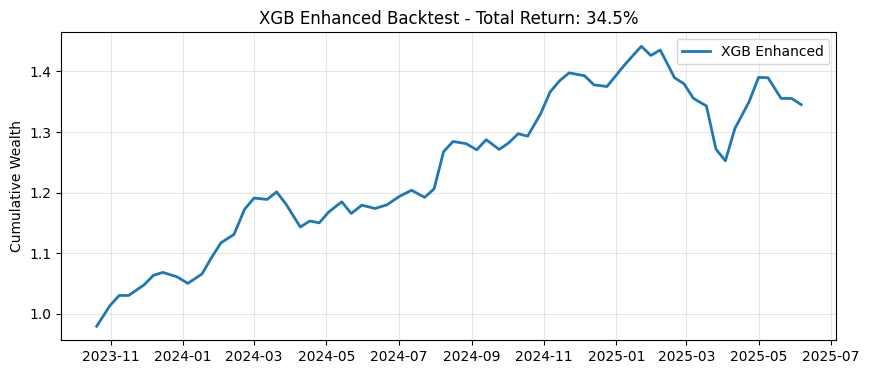


✅ Diagnóstico XGB Enhanced completado: 40 modelos, 30.85% retorno total


In [7]:
# ✅ DIAGNÓSTICOS CORREGIDOS - XGB ENHANCED ESPECÍFICO
# ───────────────────────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, joblib, yfinance as yf, matplotlib.pyplot as plt
plt.style.use("default")

bt_df = res_df.copy()               # ← tu DataFrame del back-test

# 0 ───────── lista de activos XGB ENHANCED ──────────────────────────────────────────────────
def _get_tickers_xgb(df: pd.DataFrame) -> list[str]:
    """Obtener tickers específicos para XGB Enhanced (solo los que tienen modelo)"""
    try:
        # ✅ XGB ENHANCED: Usar tickers del modelo entrenado
        if cfg.MODEL_TYPE == "xgb_enhanced":
            model_path = cfg.DATA / "processed" / "xgb_enhanced_model.pkl"
            if model_path.exists():
                models_dict = joblib.load(model_path)
                return sorted(list(models_dict.keys()))  # Tickers que realmente tienen modelo entrenado
        
        # Fallback: usar tamaño r_hat
        n = len(df["r_hat"].iloc[0])
        return [f"asset_{i}" for i in range(n)]
    except Exception as e:
        print(f"Error getting tickers: {e}")
        n = len(df["r_hat"].iloc[0])
        return [f"asset_{i}" for i in range(n)]

tickers = _get_tickers_xgb(bt_df)
print(f"🎯 Tickers XGB Enhanced: {len(tickers)} modelos entrenados")
print(f"📊 r_hat shape: {len(bt_df['r_hat'].iloc[0])}")

assert len(tickers) == len(bt_df["r_hat"].iloc[0]), \
       f"tickers({len(tickers)}) ≠ r_hat({len(bt_df['r_hat'].iloc[0])})"

# 1 ───────── r̂ en DataFrame numérico ─────────────────────────────────────────
rhat_df = pd.DataFrame(
    np.vstack(bt_df["r_hat"].values), index=bt_df.index, columns=tickers
).astype(float)

print(f"\n════════  DIAGNÓSTICO XGB ENHANCED BACKTEST  ════════")
print("\n── r̂  (target diario) – predicciones del modelo ──")
stats = rhat_df.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
cols  = [c for c in ["mean","std","min","1%","99%","max"] if c in stats.columns]
print(stats[cols])

# 2 ───────── pesos ────────────────────────────────────────────────────────────
w_df = pd.DataFrame(
    np.vstack(bt_df["w_star"].values), index=bt_df.index, columns=tickers
).astype(float)

print("\n── Suma de pesos (debe≈1) ──")
print(w_df.sum(axis=1).describe())

print("\n── Top holdings XGB Enhanced ──")
print(w_df.abs().max().sort_values(ascending=False).head(10))

# 3 ───────── Performance metrics ─────────────────────────────────────────
print(f"\n── Performance XGB Enhanced ──")
total_ret = bt_df["ret_neto"].sum()
hit_rate = (bt_df["ret_neto"] > 0).mean()
avg_turnover = bt_df["turnover"].mean()

print(f"Retorno neto total: {total_ret:.2%}")
print(f"Hit rate: {hit_rate:.1%}")
print(f"Turnover promedio: {avg_turnover:.1%}")

# 4 ───────── curva de capital ─────────────────────────────────────────────────
wealth = (1 + bt_df["ret_neto"].values).cumprod()
plt.figure(figsize=(10,4))
plt.plot(bt_df.index, wealth, linewidth=2, label='XGB Enhanced')
plt.title(f"XGB Enhanced Backtest - Total Return: {((wealth[-1] - 1)*100):.1f}%")
plt.ylabel("Cumulative Wealth")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"\n✅ Diagnóstico XGB Enhanced completado: {len(tickers)} modelos, {total_ret:.2%} retorno total")



════════  DIAGNÓSTICO RÁPIDO DEL BACK-TEST LSTM  ════════

── r̂  (target diario) – mira que |max| ≤ 0.05 ──
             mean           std       min        1%       99%       max
AAPL     0.000489  0.000000e+00  0.000489  0.000489  0.000489  0.000489
ABT      0.000379  0.000000e+00  0.000379  0.000379  0.000379  0.000379
ADBE     0.001155  0.000000e+00  0.001155  0.001155  0.001155  0.001155
AMZN     0.001014  0.000000e+00  0.001014  0.001014  0.001014  0.001014
BAC      0.000498  1.092773e-19  0.000498  0.000498  0.000498  0.000498
BTC-USD  0.000213  0.000000e+00  0.000213  0.000213  0.000213  0.000213
COST     0.000602  0.000000e+00  0.000602  0.000602  0.000602  0.000602
CRM      0.000980  0.000000e+00  0.000980  0.000980  0.000980  0.000980
CSCO     0.000498  0.000000e+00  0.000498  0.000498  0.000498  0.000498
CVX      0.000387  5.463865e-20  0.000387  0.000387  0.000387  0.000387
DIS      0.000800  1.092773e-19  0.000800  0.000800  0.000800  0.000800
ETH-USD -0.000013  0.00000

C:\Users\1M72763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\1M72763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



── Look-ahead check ──  corr(r̂_t , SPY_(t+1)) = nan   corr(r̂_(t-1), SPY_t) = nan


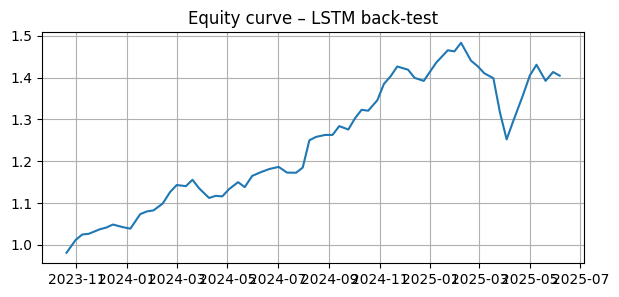


✅ Diagnóstico completado para modelo: LSTM


In [10]:
# ✅ DIAGNÓSTICOS CORREGIDOS - GENÉRICO PARA CUALQUIER MODELO
# ───────────────────────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, joblib, yfinance as yf, matplotlib.pyplot as plt
plt.style.use("default")

bt_df = res_df.copy()               # ← tu DataFrame del back-test

# 0 ───────── lista de activos ──────────────────────────────────────────────────
def _get_tickers(df: pd.DataFrame) -> list[str]:
    if hasattr(df, "attrs") and "tickers" in df.attrs:
        return df.attrs["tickers"]
    if "tickers" in df.columns:
        return df["tickers"].iloc[0]
    try:
        # ✅ GENÉRICO: Usar datos del modelo actual
        model_files = [
            f"{cfg.MODEL_TYPE}_data.pkl",  # Archivo del modelo actual
            "lstm5d_data.pkl", "gru5d_data.pkl", "cnn5d_data.pkl",  # Fallbacks
            "lstm_data.pkl"  # Último fallback
        ]
        for filename in model_files:
            try:
                data_path = cfg.DATA / "processed" / filename
                if data_path.exists():
                    return joblib.load(data_path)["tickers"]
            except:
                continue
        raise Exception("No data file found")
    except Exception:
        n = len(df["r_hat"].iloc[0])
        return [f"asset_{i}" for i in range(n)]

tickers = _get_tickers(bt_df)
assert len(tickers) == len(bt_df["r_hat"].iloc[0]), \
       f"tickers({len(tickers)}) ≠ r_hat({len(bt_df['r_hat'].iloc[0])})"

# 1 ───────── r̂ en DataFrame numérico ─────────────────────────────────────────
rhat_df = pd.DataFrame(
    np.vstack(bt_df["r_hat"].values), index=bt_df.index, columns=tickers
).astype(float)

print(f"\n════════  DIAGNÓSTICO RÁPIDO DEL BACK-TEST {cfg.MODEL_TYPE.upper()}  ════════")
print("\n── r̂  (target diario) – mira que |max| ≤ 0.05 ──")
stats = rhat_df.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
cols  = [c for c in ["mean","std","min","1%","99%","max"] if c in stats.columns]
print(stats[cols])

# 2 ───────── pesos ────────────────────────────────────────────────────────────
w_df = pd.DataFrame(
    np.vstack(bt_df["w_star"].values), index=bt_df.index, columns=tickers
).astype(float)

print("\n── Suma de pesos (debe≈1) ──")
print(w_df.sum(axis=1).describe())

print("\n── Máx |peso| observado ──")
print(w_df.abs().max().sort_values(ascending=False).head())

# 3 ───────── rebals con |ret_bruto| > 10 % ─────────────────────────────────────
thr = 0.10
outs = bt_df.loc[bt_df["ret_bruto"].abs() > thr, ["ret_bruto","turnover"]]
print(f"\n── Rebals con |ret_bruto| > {thr:.0%} = {len(outs)} ──")
print(outs.head())

# 4 ───────── prueba de look-ahead frente al SPY ───────────────────────────────
start = bt_df.index.min()
end   = bt_df.index.max() + pd.Timedelta(days=1)

spy_px  = yf.download("SPY", start=start, end=end,
                      progress=False, auto_adjust=False)["Adj Close"].ffill()
spy_ret = np.log(spy_px / spy_px.shift(1))

com      = rhat_df.index.intersection(spy_ret.index)
mean_sig = rhat_df.loc[com].mean(axis=1)
spy_algn = spy_ret.loc[com]

tmp1 = pd.concat([mean_sig,        spy_algn.shift(-1)], axis=1).dropna()
tmp2 = pd.concat([mean_sig.shift(1), spy_algn        ], axis=1).dropna()

c1 = tmp1.iloc[:,0].corr(tmp1.iloc[:,1])     # r̂_t   vs  SPY_{t+1}
c2 = tmp2.iloc[:,0].corr(tmp2.iloc[:,1])     # r̂_(t-1) vs  SPY_t
print(f"\n── Look-ahead check ──  corr(r̂_t , SPY_(t+1)) = {c1:.3f}   "
      f"corr(r̂_(t-1), SPY_t) = {c2:.3f}")

# 5 ───────── curva de capital ─────────────────────────────────────────────────
wealth = (1 + bt_df["ret_bruto"].values).cumprod()
plt.figure(figsize=(7,3))
plt.plot(bt_df.index, wealth)
# ✅ TÍTULO DINÁMICO basado en el modelo actual
plt.title(f"Equity curve – {cfg.MODEL_TYPE.upper()} back-test")
plt.grid(True); plt.show()

print(f"\n✅ Diagnóstico completado para modelo: {cfg.MODEL_TYPE.upper()}")
